## Treino e Avaliação

In [1]:
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_parquet('files/data_cleaned.parquet')

### Geração de Features

In [3]:
class FeatureGenerator:
    def __init__(self, data):
        self.data = data
        self.offers_receveid = self.data[self.data['event'] == 'offer received'].copy()
    
    def calculate_completion(self, row):
        """Verifica se a oferta foi completada após ser visualizada."""
        completed = self.data[
            (self.data['account_id'] == row['account_id']) & 
            (self.data['offer_id'] == row['offer_id']) & 
            (self.data['event'] == 'offer completed') & 
            (self.data['time_since_test_start'] >= row['time_since_test_start'])
        ]
        return 1 if not completed.empty else 0
    
    def get_time_differences(self, past_events, time):
        """Calcula tempos desde o último evento."""
        time_since_last_viewed = (
            time - past_events[past_events['event'] == 'offer viewed']
            ['time_since_test_start'].nlargest(2).iloc[-1]
            if not past_events[past_events['event'] == 'offer viewed'].empty else 0
        )
        time_since_last_transaction = (
            time - past_events[past_events['event'] == 'transaction']
            ['time_since_test_start'].max()
            if not past_events[past_events['event'] == 'transaction'].empty else 0
        )
        return time_since_last_viewed, time_since_last_transaction
    
    def calculate_duration(self, customer_data, offer_id, time):
        """Calcula a duração da oferta entre visualização e conclusão."""
        completion_event = customer_data[
            (customer_data['offer_id'] == offer_id) & 
            (customer_data['event'] == 'offer completed') & 
            (customer_data['time_since_test_start'] >= time)
        ]
        return (
            completion_event['time_since_test_start'].min() - time
            if not completion_event.empty else
            customer_data['time_since_test_start'].max() - time
        )
    
    
    def generate_features(self):
        """Gera as features para o modelo."""
        def process_row(row):
            account_id, offer_id, time, age, days_since_registration,	gender,	credit_card_limit, offer_type = row['account_id'], row['offer_id'], row['time_since_test_start'], row['age'],row['days_since_registration'],row['gender'],row['credit_card_limit'], row['offer_type']
            #customer_data = self.data[self.data['account_id'] == account_id]
            past_events = self.data[self.data['time_since_test_start'] <= time]

            receveid_offers = past_events[past_events['event'] == 'offer received']
            viewed_offers = past_events[past_events['event'] == 'offer viewed']
            completed_offers = past_events[past_events['event'] == 'offer completed']
            
            # Agregados históricos
            time_since_last_viewed, time_since_last_transaction = self.get_time_differences(past_events, time)
            duration = self.calculate_duration(self.data, offer_id, time)
            total_offers_received = len(receveid_offers)
            total_offers_viewed = len(receveid_offers)
            total_offers_completed = len(viewed_offers)
            total_transactions = len(past_events[past_events['event'] == 'transaction'])
            avg_discount_value_completed = completed_offers['discount_value'].mean() if not completed_offers.empty else 0
            avg_amount = past_events[past_events['event'] == 'transaction']['amount'].mean()
            
            # Atributos da oferta
            discount_value = self.data[self.data['offer_id'] == offer_id]['discount_value'].values[0]
            duration_max = row['duration']
            
            return pd.Series({
                "account_id": account_id,
                "offer_id": offer_id,
                "time": time,
                "age": age,
                "days_since_registration": days_since_registration,
                "gender": gender,
                "credit_card_limit": credit_card_limit,
                "offer_type": offer_type,
                "discount_value": discount_value,
                "duration": duration,
                "duration_max": duration_max,
                "total_offers_received": total_offers_received,
                "total_offers_viewed": total_offers_viewed,
                "total_offers_completed": total_offers_completed,
                "total_transactions": total_transactions,
                "avg_discount_value_completed": avg_discount_value_completed,
                "avg_amount": avg_amount,
                "time_since_last_viewed": time_since_last_viewed,
                "time_since_last_transaction": time_since_last_transaction
            })
        
        # Aplica a função em cada linha
        features = self.offers_receveid.apply(process_row, axis=1)
        return features
    
    def run(self):
        """Executa o pipeline completo."""
        # Calcular a coluna "completed"
        self.offers_receveid['completed'] = self.offers_receveid.apply(
            lambda row: self.calculate_completion(row), axis=1
        )
        
        # Gerar as features
        features = self.generate_features()
        
        # Criar a coluna de target
        features['completed'] = (
            self.offers_receveid['completed'].astype(bool) &
            (features['duration'] < features['duration_max'])
        )
        return features

### Feature Engineering

A classe `FeatureGenerator` é responsável por gerar novas variáveis (features) a partir dos dados de transações, profile ofertas. O objetivo é criar características que ajudem a melhorar a performance de um modelo preditivo, baseadas nos eventos passados de cada usuário. Abaixo estão as principais **features** geradas:

#### 1. **Contagem de Ofertas**

Utilizam informações sobre os eventos de "offer received", "offer viewed", "offer completed" e "transaction", fornecendo uma visão do comportamento do usuário em relação às ofertas.

- **`total_offers_received`**: número total de ofertas recebidas por um usuário até o momento da transação.
- **`total_offers_viewed`**: número total de ofertas visualizadas pelo usuário até o momento.
- **`total_offers_completed`**: número total de ofertas completadas, ou seja, ofertas em que o usuário realizou a ação desejada.
- **`total_transactions`**: número total de transações realizadas pelo usuário até o momento da transação.

#### 2. **Métricas de Ofertas**
São baseadas nas ofertas e transações, permitindo entender o impacto da oferta no comportamento de compra.
- **`avg_discount_value_completed`**: média do valor do desconto das ofertas completadas pelo usuário. Isso ajuda a entender a relação entre a oferta e o comportamento de compra do usuário.
- **`discount_value`**: valor do desconto da oferta atual, uma característica diretamente associada à oferta.
- **`avg_amount`**: média do valor das transações realizadas pelo usuário, fornecendo uma medida do gasto médio.


#### 3. **Tempos**
São baseadas em diferenças de tempo entre eventos, fornecendo informações sobre o comportamento temporal do usuário.
- **`time_since_last_viewed`**: tempo desde que o usuário visualizou pela última vez uma oferta. Isso ajuda a medir a recência do engajamento com as ofertas.
- **`time_since_last_transaction`**: tempo desde a última transação realizada pelo usuário, útil para entender a recência da atividade de compra.


#### 4. **Duração da Oferta**
- **`duration`**: duração da oferta, calculada como o tempo entre a visualização da oferta e sua conclusão, ou o tempo até o momento atual, caso a oferta não tenha sido concluída.
- **`duration_max`**: duração máxima da oferta, extraída diretamente das informações da oferta.


#### 5. **Atributos do Perfil do Usuário**
- **`age`**: idade do usuário.
- **`days_since_registration`**: tempo de registro do usuário na plataforma.
- **`gender`**: gênero do usuário.
- **`credit_card_limit`**: limite do cartão de crédito do usuário.

Essa etapa do código tem como objetivo gerar as features para os dados de ofertas recebidas. A ideia é dividir os dados em grupos, um por usuário (identificado pelo  `account_id`), e aplicar a geração de features para cada grupo individualmente.

In [4]:
grouped = df.groupby('account_id')
chunks_account_id = [group for _, group in grouped]

df_features_list = []
for d in tqdm(chunks_account_id):
    if (d['event'] == 'offer received').any():
        generator = FeatureGenerator(d)
        df_features_list.append(generator.run())
df_features = pd.concat(df_features_list, axis=0)

100%|██████████| 17000/17000 [05:16<00:00, 53.70it/s]


### Algumas análises úteis

**Contagem dos tipos de ofertas**

Verificar quantas ofertas foram completadas por tipo de oferta pode indicar o desempenho das ofertas em termos de conversão.

In [5]:
# Contagem dos tipos de ofertas
offer_counts = df_features["offer_type"].value_counts(normalize=True)
offer_rate_completed = df_features.groupby("offer_type").completed.mean()
pd.DataFrame(
    {
        "offer_counts": round(offer_counts, 2),
        "offer_rate_completed": round(offer_rate_completed, 2),
    }
)

,offer_counts,offer_rate_completed
offer_type,,
bogo,0.4,0.51
discount,0.4,0.58
informational,0.2,0.00


**Distribuição de Idades dos Usuários**

Analisar a distribuição de idades pode ajudar a entender o perfil demográfico dos usuários que estão interagindo com as ofertas.

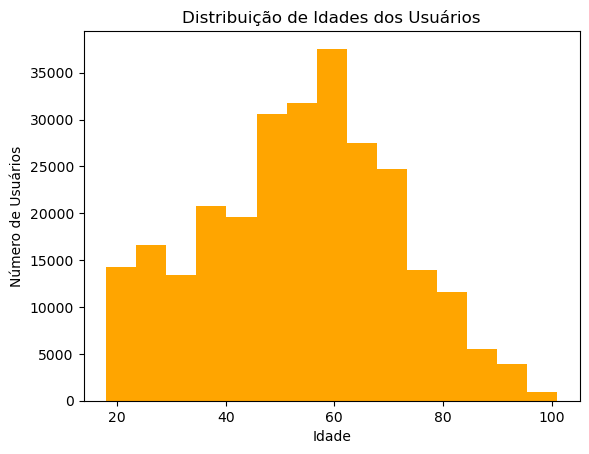

In [6]:
df['age'].plot(kind='hist', bins=15, color='orange', title="Distribuição de Idades dos Usuários")
plt.xlabel('Idade')
plt.ylabel('Número de Usuários')
plt.show()

**Análise de Gênero e Ofertas Recebidas**

Verificar a quantidade de ofertas recebidas por gênero pode indicar diferenças no engajamento com ofertas entre os gêneros.

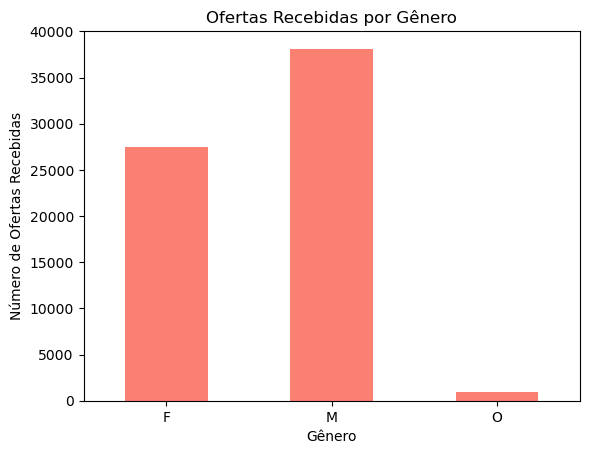

In [7]:
offer_received_by_gender = df[df['event'] == 'offer received'].groupby('gender')['offer_id'].count()

# Plotando a contagem de ofertas recebidas por gênero
offer_received_by_gender.plot(kind='bar', title="Ofertas Recebidas por Gênero", color='salmon')
plt.xlabel('Gênero')
plt.ylabel('Número de Ofertas Recebidas')
plt.xticks(rotation=0)
plt.show()

**Análise de Limite de Cartão de Crédito vs. Valor das Transações**

Explorar a relação entre o limite de crédito e o valor das transações pode ajudar a entender se existe uma correlação entre a capacidade de crédito e o comportamento de compra.

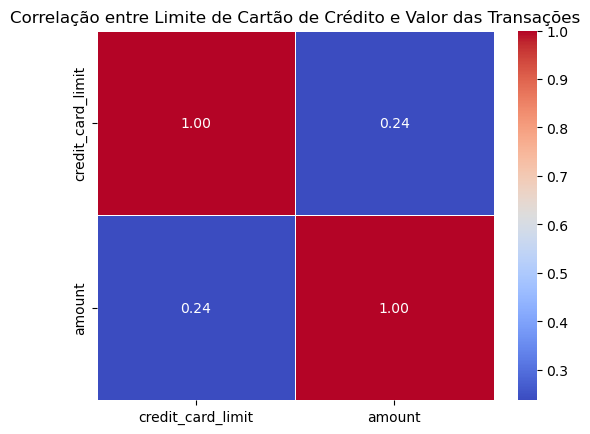

In [8]:
correlation = df[df['event'] == 'transaction'][['credit_card_limit', 'amount']].corr()

# Visualizando a correlação
import seaborn as sns
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlação entre Limite de Cartão de Crédito e Valor das Transações")
plt.show()

**Análise de Tempo de Registro e Número de Ofertas Recebidas**

Verificar se usuários com mais tempo de registro recebem mais ofertas pode ser interessante para entender o comportamento histórico dos usuários.

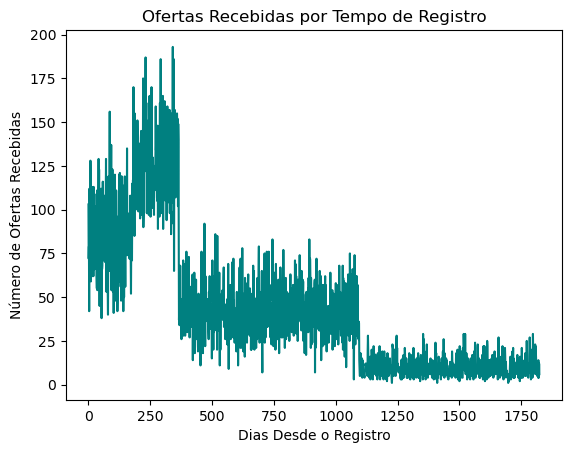

In [9]:
offer_received_by_registration_time = df[df['event'] == 'offer received'].groupby('days_since_registration')['offer_id'].count()

# Plotando a relação
offer_received_by_registration_time.plot(kind='line', title="Ofertas Recebidas por Tempo de Registro", color='teal')
plt.xlabel('Dias Desde o Registro')
plt.ylabel('Número de Ofertas Recebidas')
plt.show()

In [10]:
df

,event,account_id,time_since_test_start,amount,offer_id,age,days_since_registration,gender,credit_card_limit,offer_type,duration,discount_value
0,offer received,0009655768c64bdeb2e877511632db8f,7.00,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,461,M,72000.0,informational,3.0,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,8.00,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,461,M,72000.0,informational,3.0,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,9.50,22.16,None,33.0,461,M,72000.0,None,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,14.00,NaN,3f207df678b143eea3cee63160fa8bed,33.0,461,M,72000.0,informational,4.0,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,15.50,NaN,3f207df678b143eea3cee63160fa8bed,33.0,461,M,72000.0,informational,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,ffff82501cea40309d5fdd7edcca4a07,24.00,14.23,None,45.0,608,F,62000.0,None,NaN,NaN
306530,offer completed,ffff82501cea40309d5fdd7edcca4a07,24.00,NaN,2906b810c7d4411798c6938adc9daaa5,45.0,608,F,62000.0,discount,7.0,2.0
306531,offer viewed,ffff82501cea40309d5fdd7edcca4a07,24.25,NaN,2906b810c7d4411798c6938adc9daaa5,45.0,608,F,62000.0,discount,7.0,2.0
306532,transaction,ffff82501cea40309d5fdd7edcca4a07,25.25,10.12,None,45.0,608,F,62000.0,None,NaN,NaN


### Seleção de Features para o Modelo

As **features** selecionadas para treinar o modelo de ML visam capturar informações demográficas e comportamentais dos usuários, além de detalhes das ofertas. Elas incluem:

1. **Variáveis Categóricas**:
   - **`gender`** e **`offer_type`** (tipo de oferta), que podem influenciar o comportamento de compra.

2. **Variáveis Numéricas**:
   - **`credit_card_limit`** (transformada logaritmicamente para tratar outliers),
   - **`age`**, **`days_since_registration`**, **`discount_value`**, **`duration_max`**, **`total_offers_received`**, **`total_offers_completed`**, **`total_transactions`**, **`avg_discount_value_completed`**, **`avg_amount`**, **`time_since_last_viewed`** e **`time_since_last_transaction`**.

Essas **features** ajudam a prever a probabilidade de uma oferta ser completada, considerando o comportamento passado do usuário e características das ofertas. A variável dependente (`y`) é a coluna **`completed`**, indicando se a oferta foi completada ou não. Ofertas **informativas** foram excluídas.

In [11]:
def log_transform(x):
    return np.log1p(x)


# Definindo as colunas
cat_features = ["gender", "offer_type"]
num_log_features = ["credit_card_limit"]
num_features = [
    "age",
    "days_since_registration",
    "discount_value",
    "duration_max",
    "total_offers_received",
    "total_offers_completed",
    "total_transactions",
    "avg_discount_value_completed",
    "avg_amount",
    "time_since_last_viewed",
    "time_since_last_transaction",
]
columns = cat_features + num_features + num_log_features
df_features = df_features[df_features.offer_type != 'informational']
X = df_features[columns]
y = df_features["completed"]

In [12]:
df_features

,account_id,offer_id,time,age,days_since_registration,gender,credit_card_limit,offer_type,discount_value,duration,duration_max,total_offers_received,total_offers_viewed,total_offers_completed,total_transactions,avg_discount_value_completed,avg_amount,time_since_last_viewed,time_since_last_transaction,completed
5,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,33.0,461,M,72000.0,bogo,5.0,0.25,5.0,3,3,2,1,0.0,22.160000,9.00,7.50,True
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,33.0,461,M,72000.0,discount,2.0,1.00,10.0,4,4,3,2,5.0,15.365000,5.50,3.75,True
14,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,33.0,461,M,72000.0,discount,2.0,0.00,7.0,5,5,4,5,3.0,13.734000,5.00,0.00,True
20,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,7.0,NaN,92,None,NaN,bogo,5.0,19.25,5.0,1,1,0,0,0.0,NaN,0.00,0.00,False
25,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,24.0,NaN,92,None,NaN,bogo,5.0,2.25,5.0,2,2,1,3,0.0,1.363333,15.00,4.25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306507,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.0,45.0,608,F,62000.0,discount,5.0,1.25,10.0,2,2,1,3,2.0,10.786667,6.75,2.00,True
306515,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14.0,45.0,608,F,62000.0,discount,2.0,2.00,7.0,3,3,2,8,3.5,16.091250,13.75,1.00,True
306519,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17.0,45.0,608,F,62000.0,discount,2.0,0.25,7.0,4,4,3,9,3.0,16.033333,9.75,1.00,True
306524,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,45.0,608,F,62000.0,bogo,5.0,0.00,7.0,5,5,4,12,3.2,15.234167,6.25,0.00,True


In [13]:
df_features.completed.mean()

0.5438059041315816

### Treino

In [14]:
cat_features = ["gender", "offer_type"]
num_features = [
    "age",
    "credit_card_limit",
    "days_since_registration",
    "discount_value",
    "duration_max",
    "total_offers_received",
    "total_offers_completed",
    "total_transactions",
    "avg_discount_value_completed",
    "avg_amount",
    "time_since_last_viewed",
    "time_since_last_transaction"
]
columns = cat_features + num_features

X = df_features[columns]
y = df_features["completed"]

As colunas categóricas são tratadas com um imputer que preenche valores ausentes com o valor "-1". 

As colunas numéricas são tratadas com um imputer que preenche valores ausentes com a mediana de cada coluna, utilizando a estratégia "median".

In [15]:
def preprocess_data(transformer: ColumnTransformer, data: pd.DataFrame) -> pd.DataFrame:
    # Aplicando a transformação no conjunto de dados
    processed_data = transformer.transform(data)
    
    # Convertendo para DataFrame com as mesmas colunas
    cat_features = transformer.transformers_[0][2]  # Colunas categóricas
    num_features = transformer.transformers_[1][2]  # Colunas numéricas
    processed_df = pd.DataFrame(processed_data, columns=cat_features + num_features)
    
    return processed_df


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", SimpleImputer(missing_values=None, strategy="constant", fill_value="-1"), cat_features),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            #("scaler", StandardScaler())  # Normaliza se necessário
        ]), num_features)
    ]
)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

preprocessor.fit(X_train)
X_train_pre = preprocess_data(preprocessor, X_train)
X_test_pre = preprocess_data(preprocessor, X_test)

O CatBoost foi escolhido para o treinamento do modelo por sua eficiência em lidar com variáveis categóricas e sua capacidade de fornecer bons resultados com pouca necessidade de ajustes.

In [17]:
# Criar pools para o CatBoost (permite otimização de categóricas)
train_pool = Pool(X_train_pre, y_train, cat_features=cat_features)
test_pool = Pool(X_test_pre, y_test, cat_features=cat_features)

# Treinamento do modelo
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=100
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	test: 0.8217189	best: 0.8217189 (0)	total: 259ms	remaining: 2m 9s
100:	test: 0.8633162	best: 0.8633162 (100)	total: 8.57s	remaining: 33.8s
200:	test: 0.8659706	best: 0.8659764 (198)	total: 16.6s	remaining: 24.8s
300:	test: 0.8663678	best: 0.8663914 (297)	total: 24.4s	remaining: 16.2s
400:	test: 0.8670592	best: 0.8670771 (397)	total: 32.5s	remaining: 8.02s
499:	test: 0.8671335	best: 0.8673124 (475)	total: 39.9s	remaining: 0us

bestTest = 0.8673124481
bestIteration = 475

Shrink model to first 476 iterations.


### Avaliação

In [18]:
# Previsões
y_pred = model.predict(X_test_pre)
y_proba = model.predict_proba(X_test_pre)[:, 1]

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7827831927266771
ROC AUC: 0.8673124480958636
Classification Report:
               precision    recall  f1-score   support

       False       0.77      0.75      0.76      5570
        True       0.79      0.81      0.80      6639

    accuracy                           0.78     12209
   macro avg       0.78      0.78      0.78     12209
weighted avg       0.78      0.78      0.78     12209



O modelo tem um bom desempenho geral, com a capacidade de discriminar bem entre ofertas completadas e não completadas. A métrica ROC AUC indica que ele é eficaz em identificar a classe correta, enquanto os valores de precisão, recall e F1-score são equilibrados, com uma leve vantagem para a classe "completada".

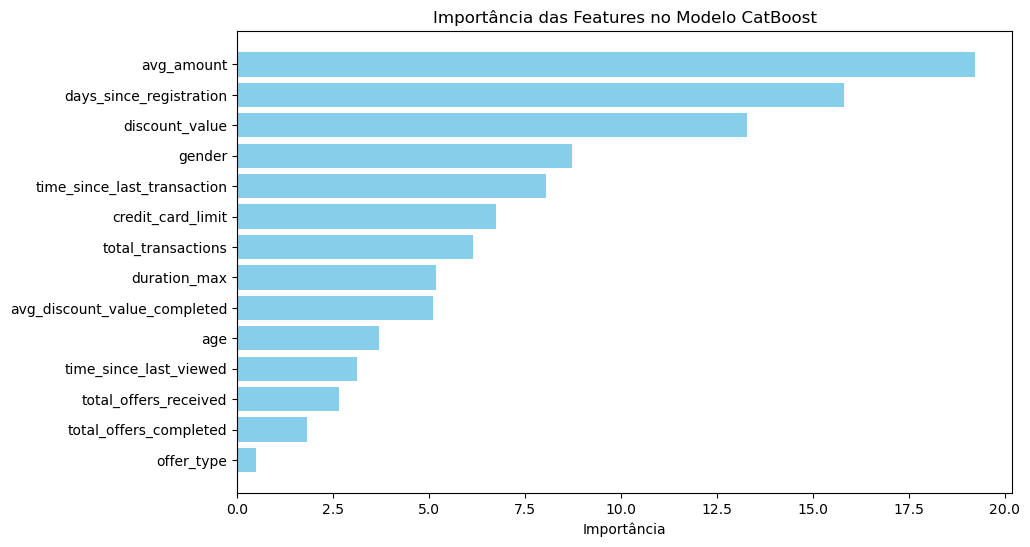

In [19]:
# Importância das features
feature_importances = model.get_feature_importance(prettified=True)
importance_df = pd.DataFrame(feature_importances)

# Ordenando as features pela importância
importance_dfa = importance_df.sort_values(by='Importances', ascending=False)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature Id'], importance_df['Importances'], color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Features no Modelo CatBoost')
plt.gca().invert_yaxis()  # Para exibir a feature mais importante no topo
plt.show()

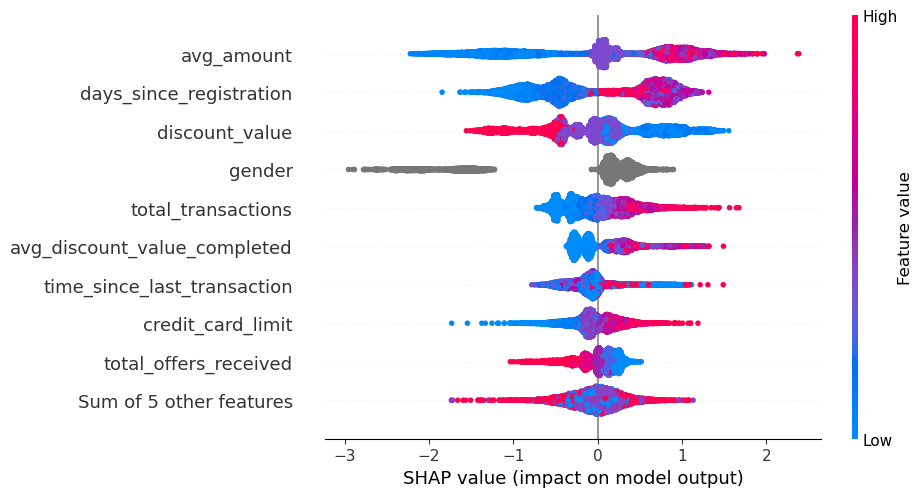

In [20]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test_pre)

shap.plots.beeswarm(shap_values)

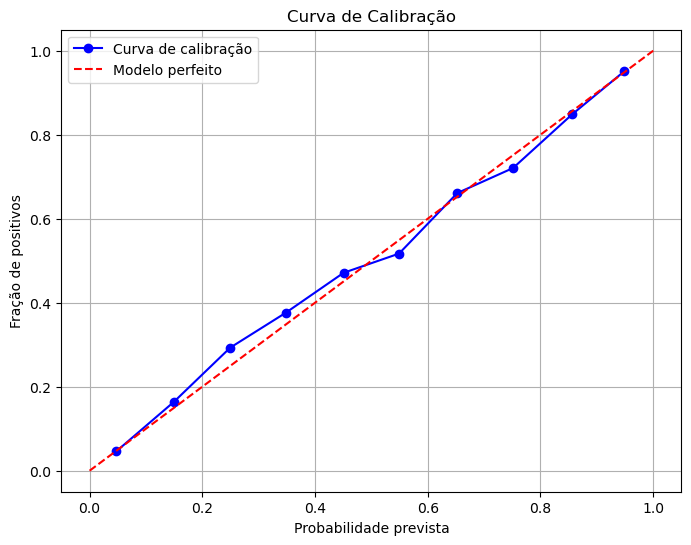

In [21]:
from sklearn.calibration import calibration_curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_proba, n_bins=10)

# Plotando a curva de calibração
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Curva de calibração', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Modelo perfeito')
plt.xlabel('Probabilidade prevista')
plt.ylabel('Fração de positivos')
plt.title('Curva de Calibração')
plt.legend()
plt.grid(True)
plt.show()


A curva de calibração indica que de fato a previsão está calibrada, ou seja, o output reflete a probabilidade de completar uma oferta.

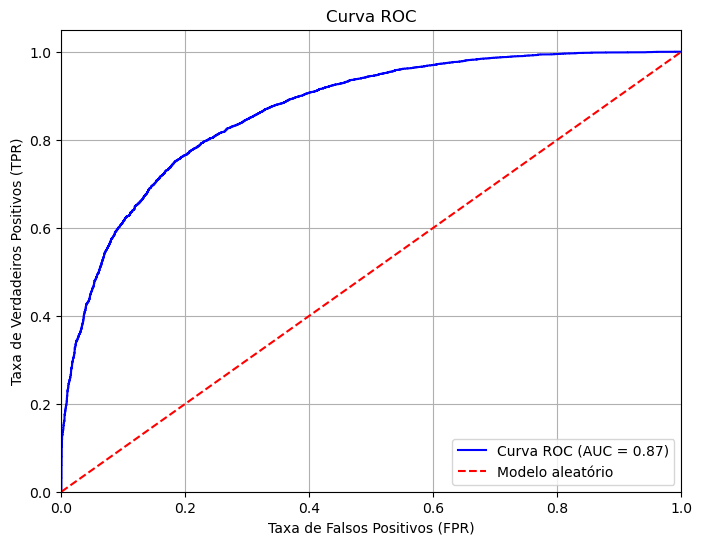

In [22]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculando a área sob a curva (AUC)
roc_auc = auc(fpr, tpr)

# Plotando a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Modelo aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Sistema de Distribuição de Ofertas

A ideia do sistema de distribuição é calcular a probabilidade de um cliente completar uma oferta que ele recebeu, e em seguida, construir uma matriz de retorno esperado com base nas probabilidades de conclusão de cada oferta para cada cliente.

In [23]:
client_features = [
    "account_id",
    "time",
    "age",
    "days_since_registration",
    "gender",
    "credit_card_limit",
    "total_offers_received",
    "total_offers_viewed",
    "total_offers_completed",
    "total_transactions",
    "avg_discount_value_completed",
    "avg_amount",
    "time_since_last_viewed",
    "time_since_last_transaction",
    "total_offers_received",
    "total_offers_completed",
]
clients_data = (
    df_features[client_features]
    .drop_duplicates(subset=["account_id"], keep="last")
    .reset_index(drop=True)
)
offers = pd.read_json("case_data/offers.json")
offers_data = offers[offers.offer_type!='informational'].rename(
    columns={"id": "offer_id", "duration": "duration_max"}
)

offer_ids = offers_data.offer_id.unique()
client_ids = clients_data.account_id.unique()

É criada uma matriz cruzada entre os clientes e as ofertas, o que significa que todas as combinações possíveis entre os clientes e as ofertas serão geradas. Isso cria uma tabela onde cada linha representa a combinação de um cliente com uma oferta específica.

In [24]:
infer_data = clients_data.merge(offers_data, how='cross')
infer_data = infer_data.loc[:, ~infer_data.columns.duplicated()]

In [25]:
cat_features = ["gender", "offer_type"]
num_features = [
    "age",
    "credit_card_limit",
    "days_since_registration",
    "discount_value",
    "duration_max",
    "total_offers_received",
    "total_offers_completed",
    "total_transactions",
    "avg_discount_value_completed",
    "avg_amount",
    "time_since_last_viewed",
    "time_since_last_transaction"
]
columns = cat_features + num_features
X_infer = preprocess_data(preprocessor, infer_data[columns])
X_infer

,gender,offer_type,age,credit_card_limit,days_since_registration,discount_value,duration_max,total_offers_received,total_offers_completed,total_transactions,avg_discount_value_completed,avg_amount,time_since_last_viewed,time_since_last_transaction
0,M,bogo,33.0,72000.0,461.0,10.0,7.0,5.0,4.0,5.0,3.0,13.734,5.0,0.0
1,M,bogo,33.0,72000.0,461.0,10.0,5.0,5.0,4.0,5.0,3.0,13.734,5.0,0.0
2,M,bogo,33.0,72000.0,461.0,5.0,7.0,5.0,4.0,5.0,3.0,13.734,5.0,0.0
3,M,discount,33.0,72000.0,461.0,5.0,10.0,5.0,4.0,5.0,3.0,13.734,5.0,0.0
4,M,discount,33.0,72000.0,461.0,3.0,7.0,5.0,4.0,5.0,3.0,13.734,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135419,F,discount,45.0,62000.0,608.0,5.0,10.0,6.0,5.0,13.0,3.0,15.156923,6.75,0.0
135420,F,discount,45.0,62000.0,608.0,3.0,7.0,6.0,5.0,13.0,3.0,15.156923,6.75,0.0
135421,F,discount,45.0,62000.0,608.0,2.0,10.0,6.0,5.0,13.0,3.0,15.156923,6.75,0.0
135422,F,bogo,45.0,62000.0,608.0,5.0,5.0,6.0,5.0,13.0,3.0,15.156923,6.75,0.0


### Matrizes de retornos experados por usuário

O retorno esperado para cada cliente e oferta é calculado multiplicando o valor médio da transação (avg_amount) pela probabilidade de completar a oferta (completed_proba). Isso indica o valor que se espera obter de cada oferta, levando em consideração a probabilidade de ela ser completada.

$$
\text{Expected Return} = \text{avg\_amount} \times \text{completed\_proba}
$$

Onde:
- $\text{avg\_amount} $ é o valor médio da transação realizada pelo cliente (a média do valor gasto nas transações passadas).
- $ \text{completed\_proba} $ é a probabilidade prevista de o cliente completar a oferta, obtida pelo modelo.

A ideia é usar essa métrica para **priorizar as ofertas com maior retorno esperado** em campanhas de marketing, otimizando as chances de conversão.

In [54]:
infer_data['completed_proba'] = model.predict_proba(X_infer)[:, 1]
infer_data['expected_return'] = X_infer.avg_amount*infer_data.completed_proba
matrix = infer_data.pivot(index='account_id', columns='offer_id', values='expected_return')
matrix

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
account_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,12.917347,13.646113,13.522946,13.192954,13.500044,13.407032,13.389798,13.654727
00116118485d4dfda04fdbaba9a87b5c,0.039455,0.214363,0.053331,0.018079,0.199567,0.023438,0.18984,0.175633
0011e0d4e6b944f998e987f904e8c1e5,7.732154,11.153073,10.172707,10.134667,10.948305,10.895252,10.550693,10.70652
0020c2b971eb4e9188eac86d93036a77,22.895648,24.01888,23.357984,23.371757,23.495824,23.670007,23.271737,24.289638
0020ccbbb6d84e358d3414a3ff76cffd,12.299476,13.397107,12.947414,12.441856,13.04044,12.872029,12.839599,13.433247
...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,24.610365,44.715929,34.344952,40.015569,38.432631,38.619615,42.896193,46.782446
fff7576017104bcc8677a8d63322b5e1,0.39528,2.118218,1.086158,0.257162,1.259541,0.343091,1.188927,1.839799
fff8957ea8b240a6b5e634b6ee8eafcf,0.27623,1.148952,0.499833,0.11603,0.718708,0.141623,0.692029,1.04232


In [55]:
best_offer = matrix.idxmax(axis=1)
max_value = matrix.max(axis=1)

In [56]:
matrix['best_offer'] = best_offer
matrix['max_value'] = max_value
matrix

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,best_offer,max_value
account_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,12.917347,13.646113,13.522946,13.192954,13.500044,13.407032,13.389798,13.654727,fafdcd668e3743c1bb461111dcafc2a4,13.654727
00116118485d4dfda04fdbaba9a87b5c,0.039455,0.214363,0.053331,0.018079,0.199567,0.023438,0.18984,0.175633,2298d6c36e964ae4a3e7e9706d1fb8c2,0.214363
0011e0d4e6b944f998e987f904e8c1e5,7.732154,11.153073,10.172707,10.134667,10.948305,10.895252,10.550693,10.70652,2298d6c36e964ae4a3e7e9706d1fb8c2,11.153073
0020c2b971eb4e9188eac86d93036a77,22.895648,24.01888,23.357984,23.371757,23.495824,23.670007,23.271737,24.289638,fafdcd668e3743c1bb461111dcafc2a4,24.289638
0020ccbbb6d84e358d3414a3ff76cffd,12.299476,13.397107,12.947414,12.441856,13.04044,12.872029,12.839599,13.433247,fafdcd668e3743c1bb461111dcafc2a4,13.433247
...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,24.610365,44.715929,34.344952,40.015569,38.432631,38.619615,42.896193,46.782446,fafdcd668e3743c1bb461111dcafc2a4,46.782446
fff7576017104bcc8677a8d63322b5e1,0.39528,2.118218,1.086158,0.257162,1.259541,0.343091,1.188927,1.839799,2298d6c36e964ae4a3e7e9706d1fb8c2,2.118218
fff8957ea8b240a6b5e634b6ee8eafcf,0.27623,1.148952,0.499833,0.11603,0.718708,0.141623,0.692029,1.04232,2298d6c36e964ae4a3e7e9706d1fb8c2,1.148952


In [57]:
df_features

,account_id,offer_id,time,age,days_since_registration,gender,credit_card_limit,offer_type,discount_value,duration,duration_max,total_offers_received,total_offers_viewed,total_offers_completed,total_transactions,avg_discount_value_completed,avg_amount,time_since_last_viewed,time_since_last_transaction,completed
5,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,17.0,33.0,461,M,72000.0,bogo,5.0,0.25,5.0,3,3,2,1,0.0,22.160000,9.00,7.50,True
9,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,21.0,33.0,461,M,72000.0,discount,2.0,1.00,10.0,4,4,3,2,5.0,15.365000,5.50,3.75,True
14,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,33.0,461,M,72000.0,discount,2.0,0.00,7.0,5,5,4,5,3.0,13.734000,5.00,0.00,True
20,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,7.0,NaN,92,None,NaN,bogo,5.0,19.25,5.0,1,1,0,0,0.0,NaN,0.00,0.00,False
25,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,24.0,NaN,92,None,NaN,bogo,5.0,2.25,5.0,2,2,1,3,0.0,1.363333,15.00,4.25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306507,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,7.0,45.0,608,F,62000.0,discount,5.0,1.25,10.0,2,2,1,3,2.0,10.786667,6.75,2.00,True
306515,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,14.0,45.0,608,F,62000.0,discount,2.0,2.00,7.0,3,3,2,8,3.5,16.091250,13.75,1.00,True
306519,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,17.0,45.0,608,F,62000.0,discount,2.0,0.25,7.0,4,4,3,9,3.0,16.033333,9.75,1.00,True
306524,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,21.0,45.0,608,F,62000.0,bogo,5.0,0.00,7.0,5,5,4,12,3.2,15.234167,6.25,0.00,True


### Segmentação de usuários

Para determinar qual grupo de usuários deve receber ofertas, é importante identificar aqueles que têm maior sensibilidade a transações com cupons de desconto. Focar em usuários que já estão naturalmente engajados (aqueles que realizam transações sem a necessidade de cupons) pode resultar em desperdício de recursos, uma vez que esses usuários não precisam de incentivos adicionais para realizar compras.
A **taxa de dependência** (\(dependency\_rate\)) é uma medida que combina a **frequência de uso de cupons** e o **valor médio do desconto**. Ela pode ser interpretada como uma forma de mensurar o **impacto médio do desconto** (em termos de dependência de cupons) sobre o total de transações. Ou seja, quanto mais as transações dependem de cupons e quanto maior o valor do desconto, maior será a taxa de dependência.

- **num_with_coupons**: Número de pessoas ou transações que utilizaram cupons de desconto.
- **num_without_coupons**: Número de pessoas ou transações que não utilizaram cupons de desconto.
- **avg_discount_with_coupons**: O valor médio de desconto aplicado às transações que utilizaram cupons.

$$
\text{dependency\_rate} = \left( \frac{\text{num\_with\_coupons}}{\text{num\_with\_coupons} + \text{num\_without\_coupons}} \right) \times \text{avg\_discount\_with\_coupons}
$$

Uma **taxa de dependência** elevada pode indicar que a empresa depende significativamente de cupons para atrair clientes ou gerar vendas. Descontos mais altos tendem a ter um impacto maior nas decisões de compra, sugerindo que a estratégia de oferecer cupons pode ser uma maneira eficaz de aumentar as transações. Por outro lado, uma taxa de dependência baixa pode indicar que os clientes realizam compras independentemente de ofertas, o que pode ser sinal de um público já engajado ou de um modelo de negócios que não depende tanto de promoções.

In [38]:
def calculate_dependency_rate(df_client):
    # Calcular o número de transações com e sem cupons
    df_client = df_client.drop_duplicates(subset=['event', 'time_since_test_start'])
    num_with_coupons = len(df_client[df_client.event == 'offer completed'])
    num_without_coupons = len(df_client[df_client.event == 'transaction']) - num_with_coupons
    
    # Substituir NaN por 0 no desconto antes de calcular a média
    avg_discount_with_coupons = df_client[df_client.event == 'offer completed'].discount_value.fillna(0).mean()
    
    # Calcular a taxa de dependência
    if num_with_coupons + num_without_coupons > 0:
        dependency_rate = (num_with_coupons / (num_with_coupons + num_without_coupons))*avg_discount_with_coupons
    else:
        dependency_rate = 0  # Se não houver transações, a taxa de dependência é 0
    
    return dependency_rate

Vamos calcular as taxas de dependência para cada cliente.

In [39]:
# Agrupar o dataframe por cliente (account_id) e aplicar a função
dependency_rates = df.groupby('account_id').apply(calculate_dependency_rate)

# Exibir as taxas de dependência para cada cliente
dependency_rates = pd.DataFrame(dependency_rates).reset_index().rename(columns={0:'rate'})

C:\Users\bruno\AppData\Local\Temp\ipykernel_34392\634135310.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dependency_rates = df.groupby('account_id').apply(calculate_dependency_rate)


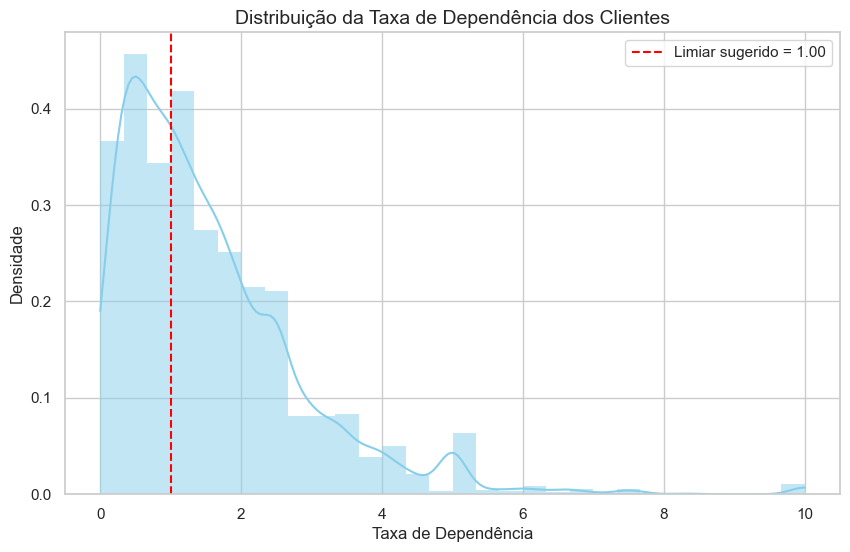

In [40]:
# Supondo que dependency_rates já tenha sido calculado e seja um DataFrame com a coluna 'rate'
# Exemplo: dependency_rates = pd.DataFrame({'account_id': ['A', 'B', 'C'], 'rate': [0.1, 0.3, 0.2]})

# Configuração de estilo do gráfico
sns.set(style="whitegrid")

# Plotando o histograma da dependency rate
plt.figure(figsize=(10, 6))
sns.histplot(dependency_rates['rate'], bins=30, kde=True, color='skyblue', stat='density', linewidth=0)

threshold = 1  # Exemplo de limiar, pode ser ajustado
plt.axvline(x=threshold, color='red', linestyle='--', label=f'Limiar sugerido = {threshold:.2f}')

# Títulos e rótulos
plt.title('Distribuição da Taxa de Dependência dos Clientes', fontsize=14)
plt.xlabel('Taxa de Dependência', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()

# Exibindo o gráfico
plt.show()


Este limiar pode ser ajustado com base na distribuição ou objetivo do negócio.

A segmentação dos clientes será feita em dois grupos principais com base na **taxa de dependência**:

1. **Grupo Acima do Limiar**: Clientes com taxa de dependência superior ao limiar especificado. Esse grupo será priorizado para o envio de ofertas, pois possuem maior probabilidade de responder positivamente a cupons de desconto.

2. **Grupo Sem Transações**: Clientes que não possuem uma taxa de dependência registrada (valores `NaN`), o que indica que não realizaram transações que possam ser associadas a cupons.

O **outro grupo**, com clientes abaixo do limiar de dependência, pode ser analisado separadamente para entender seu comportamento em relação às ofertas, mas não será o foco imediato para a distribuição de cupons.

In [41]:
group_without_transactions = set(dependency_rates[dependency_rates.rate.isna()].account_id)
group_below_threshold = set(dependency_rates[dependency_rates.rate<=threshold].account_id)
group_above_threshold = set(dependency_rates[dependency_rates.rate>threshold].account_id)

In [42]:
offer_limits = {i: 100 for i in offer_ids}
matrix_group_above_threshold = matrix[matrix.index.isin(group_above_threshold)]

In [43]:
def greedy_offer_allocation(matrix_df, offer_limits, random=False):
    matrix = matrix_df.to_numpy()
    
    # Pega os account_ids e offer_ids
    account_ids = matrix_df.index.to_numpy()
    offer_names = list(offer_limits.keys())
    offer_ids = np.array(offer_names)
    
    allocations = {} 
    remaining_offers = offer_limits.copy()
    remaining_clients = np.arange(matrix.shape[0])

    # Continua enquanto houver ofertas restantes e clientes
    while len(remaining_clients) > 0 and any(remaining_offers.values()):
        for offer_idx, offer in enumerate(offer_ids):
            if remaining_offers[offer] <= 0:
                continue  # Pula se a oferta já foi esgotada

            # Filtra as probabilidades dos clientes restantes para a oferta atual
            filtered_probs = matrix[remaining_clients, offer_idx]

            if filtered_probs.size == 0:
                continue
            if not random:
                best_client_idx = np.argmax(filtered_probs)
            else:
                best_client_idx = np.random.choice(len(filtered_probs))
            # Atribui a oferta ao cliente
            best_client = remaining_clients[best_client_idx]
            allocations[account_ids[best_client]] = offer

            # Atualiza os limites e remove o cliente
            remaining_offers[offer] -= 1
            remaining_clients = np.delete(remaining_clients, best_client_idx)

            # Para de distribuir esta oferta se o limite chegar a zero
            if remaining_offers[offer] <= 0:
                break

    return allocations


In [44]:

allocations = greedy_offer_allocation(matrix_group_above_threshold, offer_limits)
allocations_random = greedy_offer_allocation(matrix_group_above_threshold, offer_limits, random=True)

print("Alocações finais:")
print(allocations)


Alocações finais:
{'ef375083fcf44eb8bc2131591e8bd2d1': 'ae264e3637204a6fb9bb56bc8210ddfd', '0cc6e8553c844c02ab525bc466aa569b': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'ad1f0a409ae642bc9a43f31f56c130fc': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'b153707a382046218a55e0122b4dcf37': '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'ff2113310abe4c6687569bdd8f028fe3': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'c2390da2832148358ec29931c0487885': 'fafdcd668e3743c1bb461111dcafc2a4', 'bfce6d50205a4f6982d87ce80e5d5356': 'f19421c1d4aa40978ebb69ca19b0e20d', '5ecaea5c8bf44ae4a65838d9d066c909': '2906b810c7d4411798c6938adc9daaa5', '3e2654232d3c479e88b817fbf3cf6ee1': 'ae264e3637204a6fb9bb56bc8210ddfd', '04f1f44632cd409cace939fa62b5fc7a': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'a73cf044395d46ea804f688490ad9227': '9b98b8c7a33c4b65b9aebfe6a799e6d9', '7561a0a081e64e118bbc78818c890ab7': '0b1e1539f2cc45b7b9fa7c272da2e1d7', 'cea97a52bddc4a0e9c6c54f30c78253b': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'a12fba072dae4e3aae2e1b4b92b92aa1': 'fafdcd66

In [45]:
s = []
for i, j in allocations.items():
    s.append(matrix.loc[i, j])

s_random = []
for i, j in allocations_random.items():
    s_random.append(matrix.loc[i, j])

O início da lista tende a ter valores maiores, pois, no início do processo de distribuição, a matriz de alocação (de clientes e ofertas) possuía uma maior disponibilidade de clientes com alta receita. Ou seja, as primeiras ofertas foram direcionadas a clientes com maior potencial de retorno financeiro.

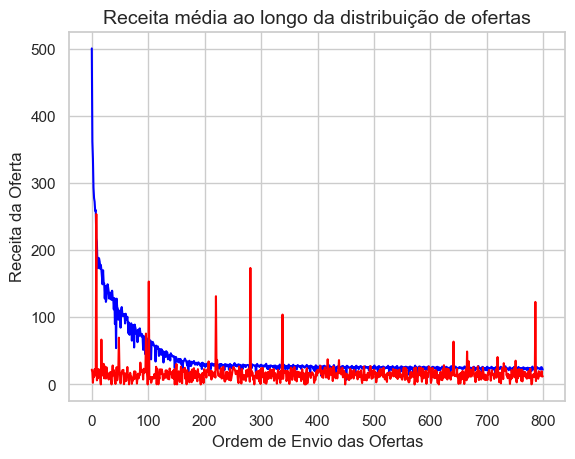

In [46]:
plt.plot(s, color='blue')
plt.plot(s_random, color='red')

# Adicionando título e rótulos aos eixos
plt.title('Receita média ao longo da distribuição de ofertas', fontsize=14)
plt.xlabel('Ordem de Envio das Ofertas', fontsize=12)
plt.ylabel('Receita da Oferta', fontsize=12)

# Exibindo o gráfico
plt.grid(True)

In [37]:
df

,event,account_id,time_since_test_start,amount,offer_id,age,days_since_registration,gender,credit_card_limit,offer_type,duration,discount_value
0,offer received,0009655768c64bdeb2e877511632db8f,7.00,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,461,M,72000.0,informational,3.0,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,8.00,NaN,5a8bc65990b245e5a138643cd4eb9837,33.0,461,M,72000.0,informational,3.0,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,9.50,22.16,None,33.0,461,M,72000.0,None,NaN,NaN
3,offer received,0009655768c64bdeb2e877511632db8f,14.00,NaN,3f207df678b143eea3cee63160fa8bed,33.0,461,M,72000.0,informational,4.0,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,15.50,NaN,3f207df678b143eea3cee63160fa8bed,33.0,461,M,72000.0,informational,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,ffff82501cea40309d5fdd7edcca4a07,24.00,14.23,None,45.0,608,F,62000.0,None,NaN,NaN
306530,offer completed,ffff82501cea40309d5fdd7edcca4a07,24.00,NaN,2906b810c7d4411798c6938adc9daaa5,45.0,608,F,62000.0,discount,7.0,2.0
306531,offer viewed,ffff82501cea40309d5fdd7edcca4a07,24.25,NaN,2906b810c7d4411798c6938adc9daaa5,45.0,608,F,62000.0,discount,7.0,2.0
306532,transaction,ffff82501cea40309d5fdd7edcca4a07,25.25,10.12,None,45.0,608,F,62000.0,None,NaN,NaN
